In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import yellowbrick as yb

In [2]:
#Loading dataset
df = pd.read_csv('Data/Providers_Updated_430.txt', sep='\t', low_memory=False)
df.head()

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_mi,nppes_provider_gender,nppes_entity_code,nppes_provider_street1,nppes_provider_city,nppes_provider_zip5,specialty_description,...,beneficiary_nondual_count,beneficiary_dual_count,beneficiary_average_risk_score,EXCLYear,REINYear,excl_type,exclusion_flag,country,state,nppes_credentials
0,1003000126,ENKESHAFI,ARDALAN,NaN,M,I,900 SETON DR,CUMBERLAND,21502.0,Internal Medicine,...,143.0,91.0,2.1685,NaN,NaN,NaN,0,US,MD,Medical Doctor
1,1003000142,KHALIL,RASHID,NaN,M,I,4126 N HOLLAND SYLVANIA RD,TOLEDO,43623.0,Surgery,...,143.0,133.0,1.8029,NaN,NaN,NaN,0,US,OH,Medical Doctor
2,1003000167,ESCOBAR,JULIO,E,M,I,5 PINE CONE RD,DAYTON,89403.0,Dentist,...,NaN,NaN,1.0598,NaN,NaN,NaN,0,US,NV,Dentist/DDS
3,1003000175,REYES-VASQUEZ,BELINDA,NaN,F,I,322 N AZUSA AVE STE 202,LA PUENTE,91744.0,Dentist,...,NaN,NaN,NaN,NaN,NaN,NaN,0,US,CA,Dentist/DDS
4,1003000282,BLAKEMORE,ROSIE,K,F,I,TENNESSEE PRISON FOR WOMEN,NASHVILLE,37243.0,Nurse,...,NaN,NaN,4.5148,NaN,NaN,NaN,0,US,TN,Nurse


In [3]:
df.shape

(1162898, 76)

## Looking at values in categorical variables after cleaning these variables

Categorical columns that may serve as features include: nppes_credentials, nppes_provider_gender, state, country, specialty_description, medicare_prvdr_enroll_status

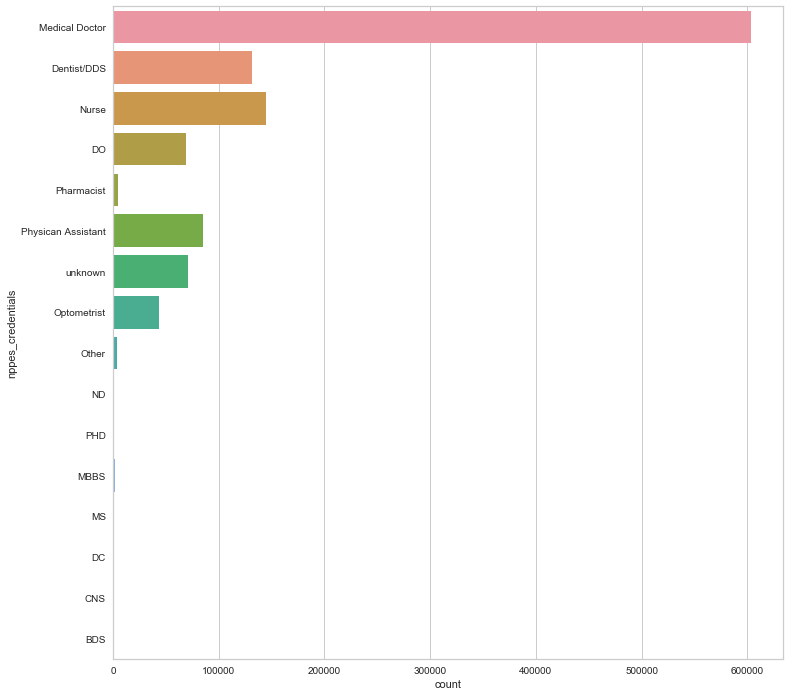

In [4]:
#Looking at credentials as a possible feature so reviewing how many unique types there are
f, ax = plt.subplots(figsize=(12, 12))
ax = sns.countplot(y='nppes_credentials', data=df)

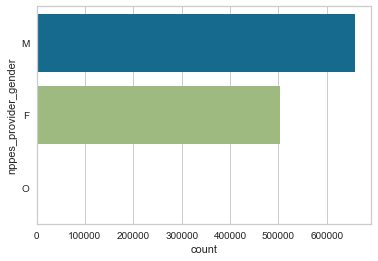

In [5]:
#Looking at gender, the 3 null values are organizations per the data documentation so replacing with 'O'
df['nppes_provider_gender'] = df['nppes_provider_gender'].fillna('O')
ax = sns.countplot(y='nppes_provider_gender', data=df)

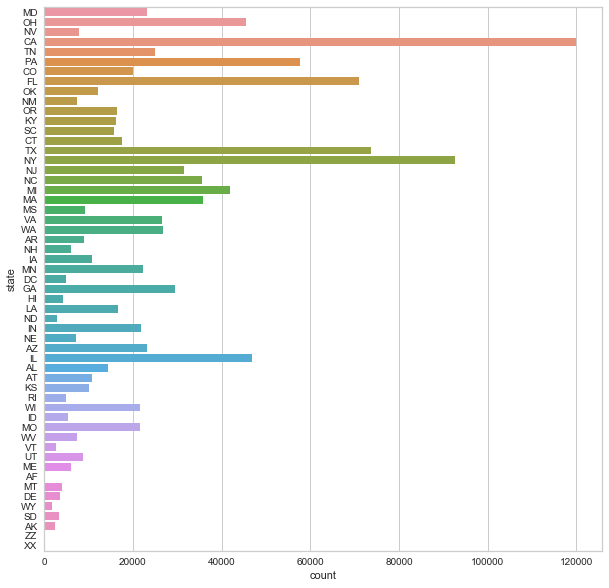

In [6]:
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.countplot(y='state', data=df)

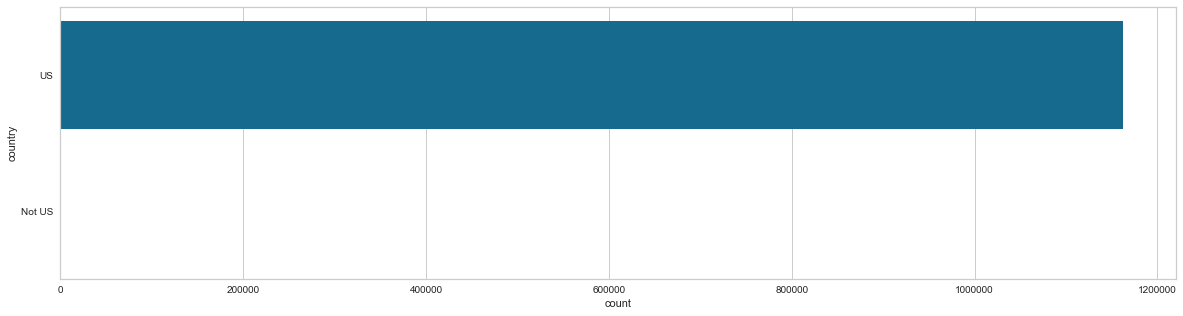

In [7]:
f, ax = plt.subplots(figsize=(20, 5))
ax = sns.countplot(y='country', data=df)

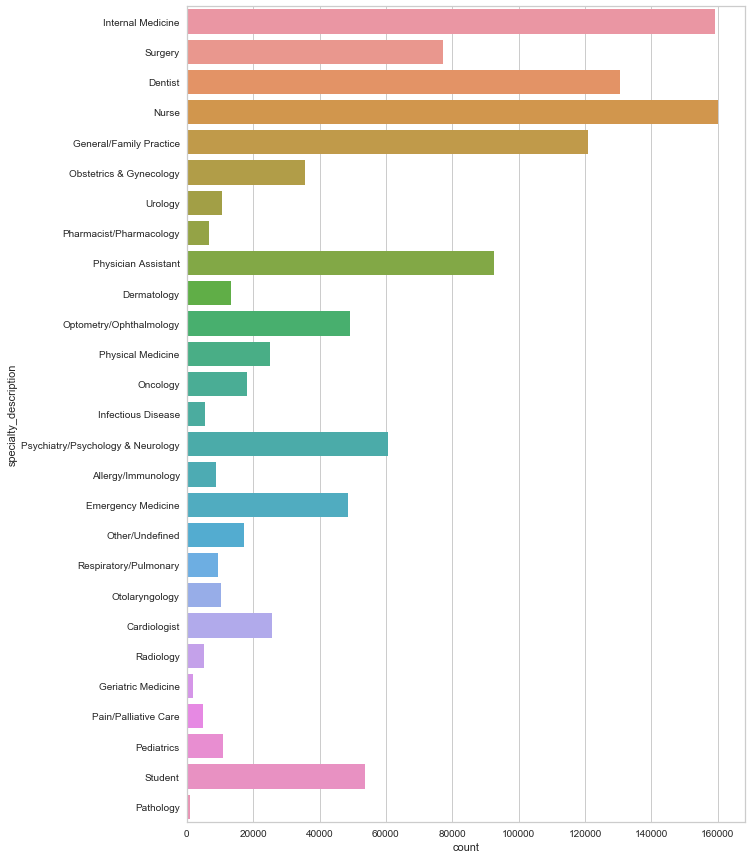

In [8]:
f, ax = plt.subplots(figsize=(10, 15))
ax = sns.countplot(y='specialty_description', data=df)

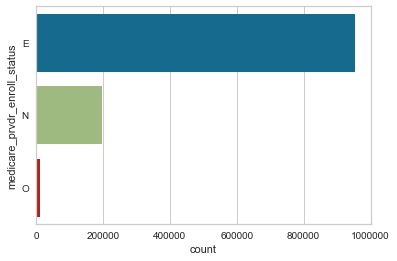

In [9]:
ax = sns.countplot(y='medicare_prvdr_enroll_status', data=df)

# Suppression Flags

All with a * suppression is because the claim count for that category is < 11. If the suppression is marked with a #, it's because a corresponding category is < 11 so can be mathematically calculated by providing this number. Therefore will change this is a categorical columns as suppressed or counter suppressed

In [10]:
#Renaming values in the suppress flags
suppress_flags = ['ge65_suppress_flag', 'bene_count_ge65_suppress_flag', 'brand_suppress_flag', 'generic_suppress_flag', 'other_suppress_flag', 'mapd_suppress_flag', 'pdp_suppress_flag', 'lis_suppress_flag', 'nonlis_suppress_flag', 'antipsych_ge65_suppress_flag', 'antipsych_bene_ge65_suppress_flg']
df[suppress_flags] = df[suppress_flags].replace({'*': 'suppressed', '#': 'counter suppressed'})
#In first data transformation missed a couple of the suppression flag fields so imputing for those na values as well
df[suppress_flags] = df[suppress_flags].fillna('not suppressed')

In [11]:
#Confirming conversions worked correctly
df['ge65_suppress_flag'].value_counts()

not_suppressed        910442
counter suppressed    204945
suppressed             47511
Name: ge65_suppress_flag, dtype: int64

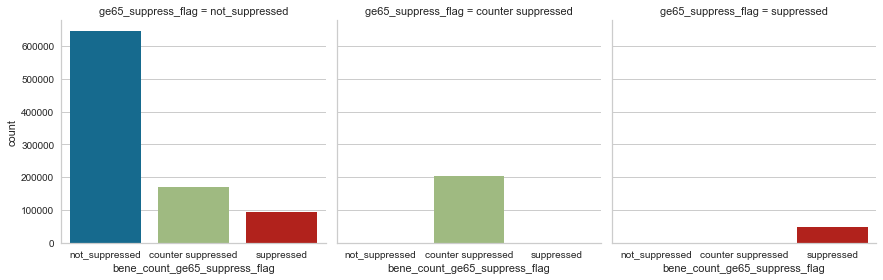

In [12]:
#Exploring the connection between the suppression flags that are related to each other
g = sns.catplot('bene_count_ge65_suppress_flag', col='ge65_suppress_flag', col_wrap=4, 
                   data=df, kind="count", height=4, aspect=1)

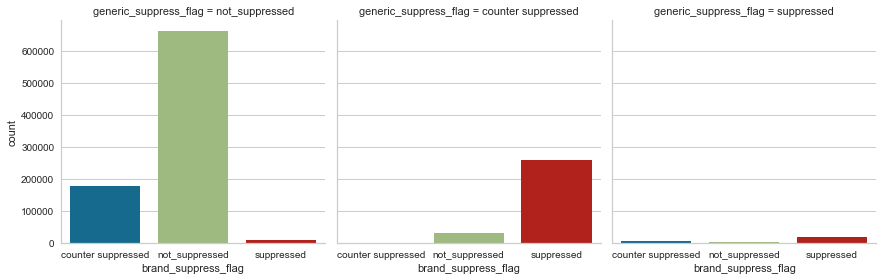

In [13]:
g = sns.catplot('brand_suppress_flag', col='generic_suppress_flag', col_wrap=4, 
                   data=df, kind="count", height=4, aspect=1)

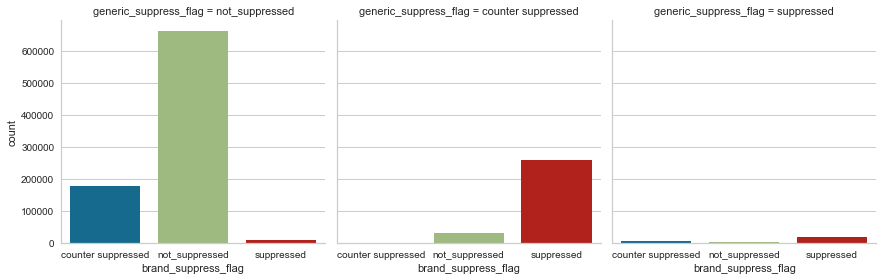

In [14]:
g = sns.catplot('brand_suppress_flag', col='generic_suppress_flag', col_wrap=4, 
                   data=df, kind="count", height=4, aspect=1)

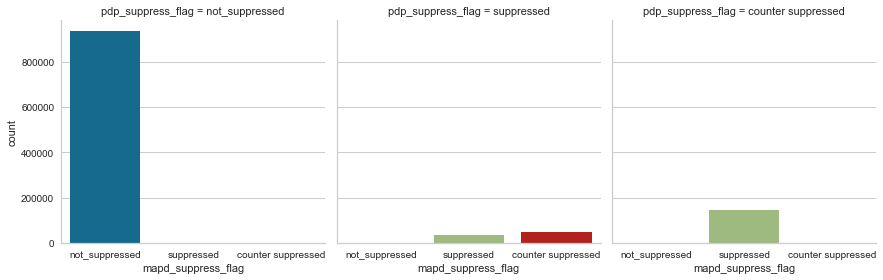

In [15]:
g = sns.catplot('mapd_suppress_flag', col='pdp_suppress_flag', col_wrap=4, 
                   data=df, kind="count", height=4, aspect=1)

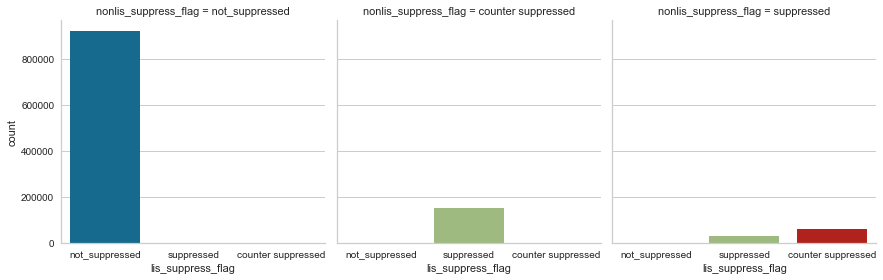

In [16]:
g = sns.catplot('lis_suppress_flag', col='nonlis_suppress_flag', col_wrap=4, 
                   data=df, kind="count", height=4, aspect=1)

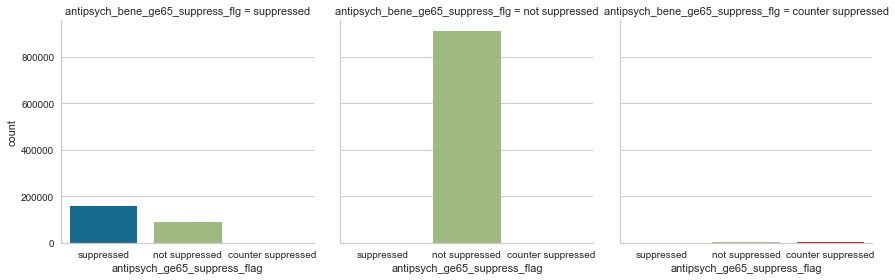

In [17]:
g = sns.catplot('antipsych_ge65_suppress_flag', col='antipsych_bene_ge65_suppress_flg', col_wrap=4, 
                   data=df, kind="count", height=4, aspect=1)

## Exploring continuous variables
According to documentation for the dataset, if the following categories are less than 11, this number is suppressed, resulting in null values: bene_count, total_claim_count, opioid_claim_count, la_opiod_claim_count, antiobiotic_claim_count, opioid_bene_count, and la_opioid_bene_count. Therefore, to use this as a feature in our model, we can impute the null values with 5 as this is the average number that these values could be if it is less than 11. Another option would be to transform them into categorical variables and all of these null values would fall in a category of < 11. Before making this decision, will look at the distribution of these variables as well as a few other key variables that do not have null values.

In [18]:
#focusing in on possible key features with no null values
kf = ['total_claim_count', 'total_30_day_fill_count', 'total_drug_cost', 'total_day_supply']

In [19]:
#Running statistics on these key features
df[kf].describe()

,total_claim_count,total_30_day_fill_count,total_drug_cost,total_day_supply
count,1.162898e+06,1.162898e+06,1.162898e+06,1.162898e+06
mean,1.284985e+03,1.997596e+03,1.330248e+05,5.549234e+04
std,3.094369e+03,4.686889e+03,3.623623e+05,1.314514e+05
min,1.100000e+01,1.100000e+01,0.000000e+00,1.100000e+01
25%,5.500000e+01,6.400000e+01,1.518322e+03,9.850000e+02
50%,2.030000e+02,2.410000e+02,1.008624e+04,4.685000e+03
75%,9.950000e+02,1.397200e+03,1.011364e+05,3.763975e+04
max,4.472880e+05,4.479605e+05,2.645885e+07,5.634058e+06


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023A83BD3108>,
      dtype=object)

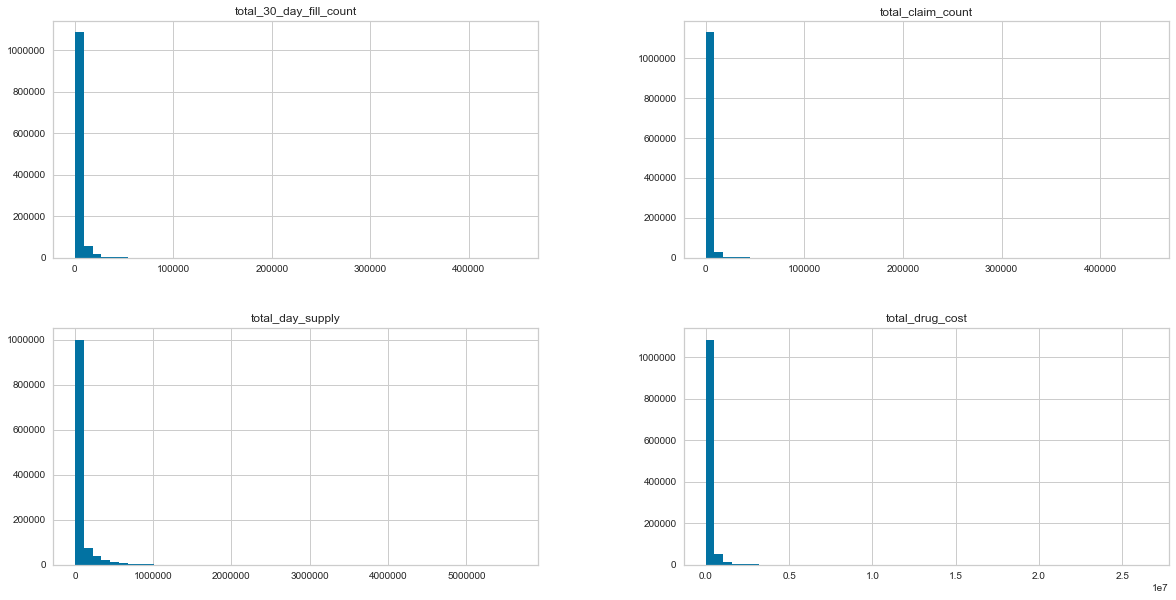

In [20]:
#Looking at histogram of these 4 features
df[kf].hist(figsize=(20,10), bins=50) 

In [21]:
#Exploring if the organizations create these outliers so filtering it look at just those
orgs = df['nppes_entity_code'] == 'O'
orgs_only = df[orgs]

In [22]:
orgs_only[kf].describe()

,total_claim_count,total_30_day_fill_count,total_drug_cost,total_day_supply
count,3.0,3.0,3.000000,3.000000
mean,13.0,13.0,1639.436667,98.333333
std,2.0,2.0,653.712166,124.343610
min,11.0,11.0,1017.410000,13.000000
25%,12.0,12.0,1298.760000,27.000000
50%,13.0,13.0,1580.110000,41.000000
75%,14.0,14.0,1950.450000,141.000000
max,15.0,15.0,2320.790000,241.000000


It is not the organizations creating outliers so should keep these three in our dataset

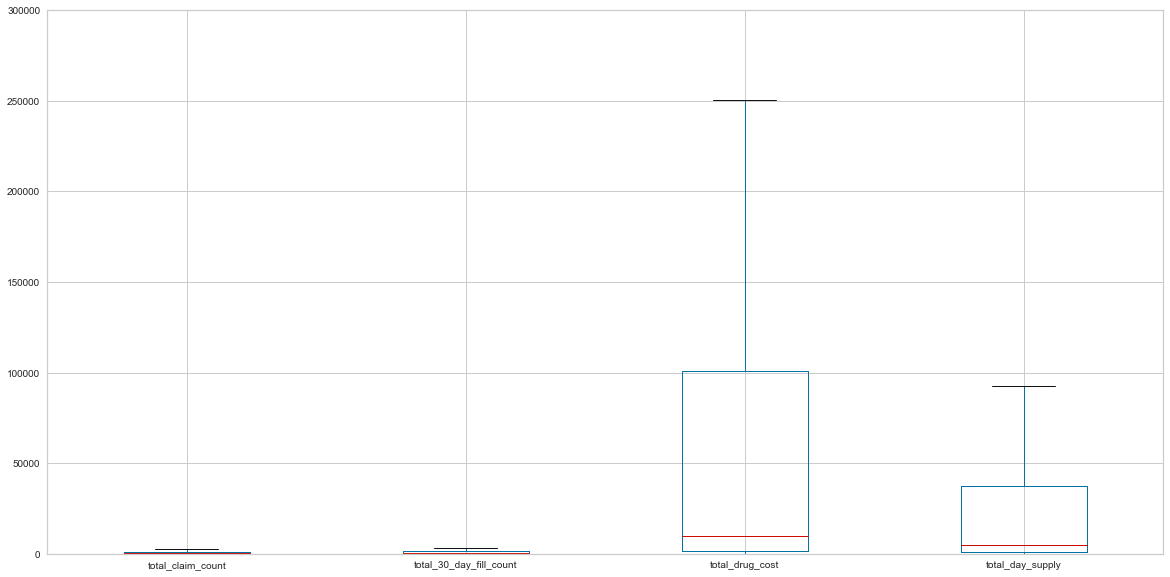

In [23]:
#Looking at box plots for these variables for all rows
df[kf].plot(kind='box',figsize=(20,10), ylim=(0, 300000))

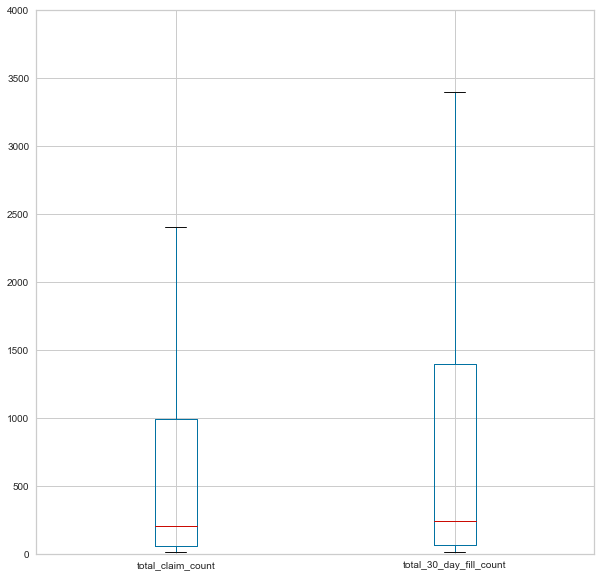

In [24]:
#As total drug cost has a much higher scale, looking at just the other two variables
kf1 = ['total_claim_count', 'total_30_day_fill_count']
df[kf1].plot(kind='box', figsize=(10,10), ylim=(0, 4000))

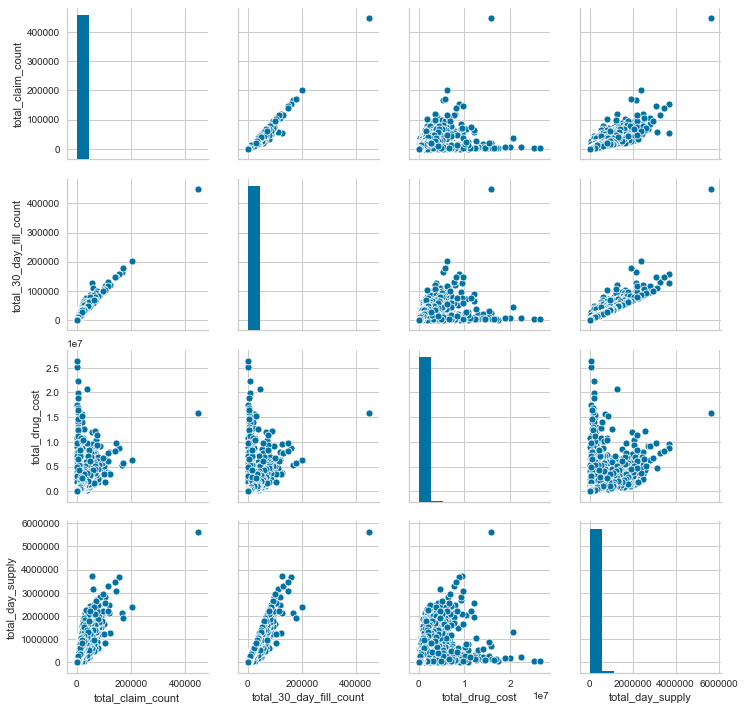

In [25]:
#Looking at relationships between these variables
g = sns.pairplot(df[kf])
plt.show()

According to the above, they all look correlated to each other, particularly total_claim_count and total_30_day_fill_count. It does make sense that the total_claim_count would be positively correlated with the others, therefore will create new variables with this as the denominator.   

In [26]:
#Calculating new variables
df['total_30_day_per_claim'] = df['total_30_day_fill_count']/df['total_claim_count']
df['drug_cost_per_claim'] = df['total_drug_cost']/df['total_claim_count']
df['day_supply_per_claim'] = df['total_day_supply']/df['total_claim_count']
calcs = ['total_30_day_per_claim', 'drug_cost_per_claim', 'day_supply_per_claim']

In [27]:
#Looking at summary statistics of the new columns
df[calcs].describe()

,total_30_day_per_claim,drug_cost_per_claim,day_supply_per_claim
count,1.162898e+06,1.162898e+06,1.162898e+06
mean,1.330646e+00,1.167502e+02,3.083781e+01
std,4.014617e-01,5.191074e+02,1.792922e+01
min,1.000000e+00,0.000000e+00,1.000000e+00
25%,1.013274e+00,2.025194e+01,1.540625e+01
50%,1.158730e+00,5.143779e+01,2.971257e+01
75%,1.530927e+00,9.006681e+01,4.250000e+01
max,6.866667e+00,1.712797e+05,2.558667e+02


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023B47DED108>,
      dtype=object)

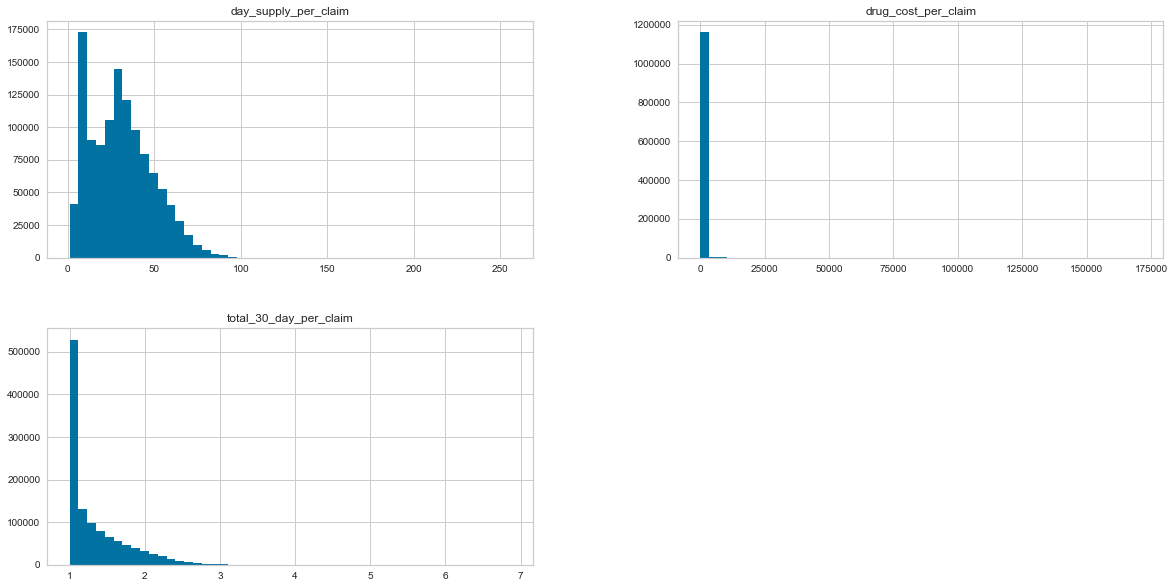

In [28]:
#Looking at the distribution of these new columns
df[calcs].hist(figsize=(20,10), bins=50)

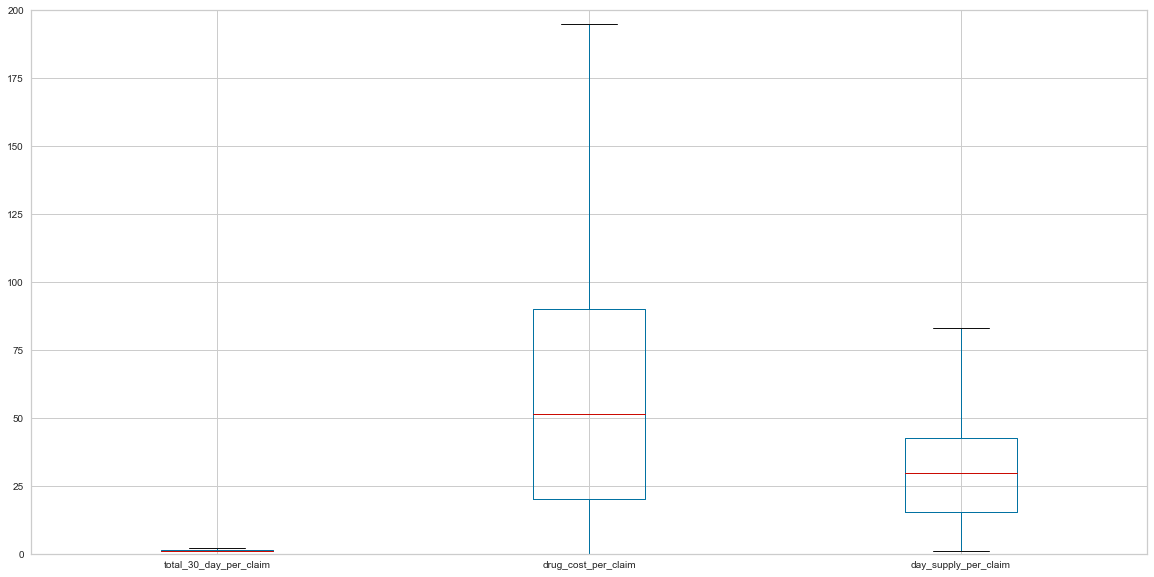

In [29]:
#Exploring variables with boxplots
df[calcs].plot(kind='box',figsize=(20,10), ylim=(0,200))

In [30]:
created = ['total_30_day_per_claim', 'drug_cost_per_claim', 'day_supply_per_claim', 'exclusion_flag']
df_created = df[created]

C:\Users\Me\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Me\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


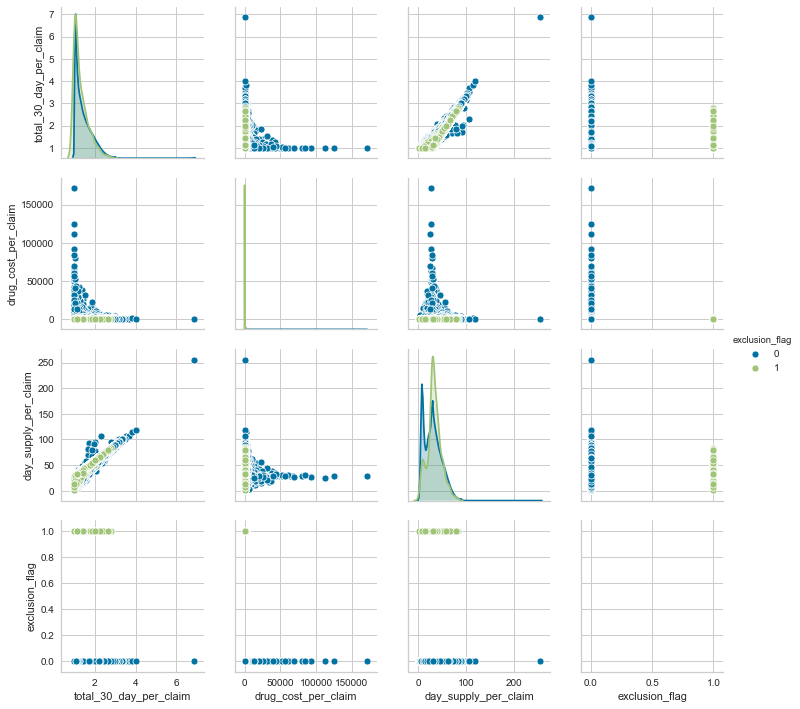

In [31]:
#Looking at if there are groupings based on other variables
g = sns.pairplot(df_created, hue='exclusion_flag')
plt.show()

In [32]:
#Focusing on beneficiary counts with null values that indicate value is < 11
kf_null = ['bene_count', 'opioid_bene_count', 'la_opioid_bene_count', 'antibiotic_bene_count']

In [33]:
df[kf_null].describe()

,bene_count,opioid_bene_count,la_opioid_bene_count,antibiotic_bene_count
count,1.162820e+06,1.162796e+06,1.162820e+06,1.162734e+06
mean,1.409731e+02,2.109960e+01,2.144948e+00,3.370077e+01
std,1.975556e+02,4.741548e+01,1.183300e+01,5.518005e+01
min,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.300000e+01,0.000000e+00,0.000000e+00,5.000000e+00
50%,6.800000e+01,5.000000e+00,0.000000e+00,1.200000e+01
75%,1.870000e+02,2.200000e+01,0.000000e+00,4.100000e+01
max,3.996500e+04,3.270000e+03,1.131000e+03,2.014000e+03


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023A85129908>,
      dtype=object)

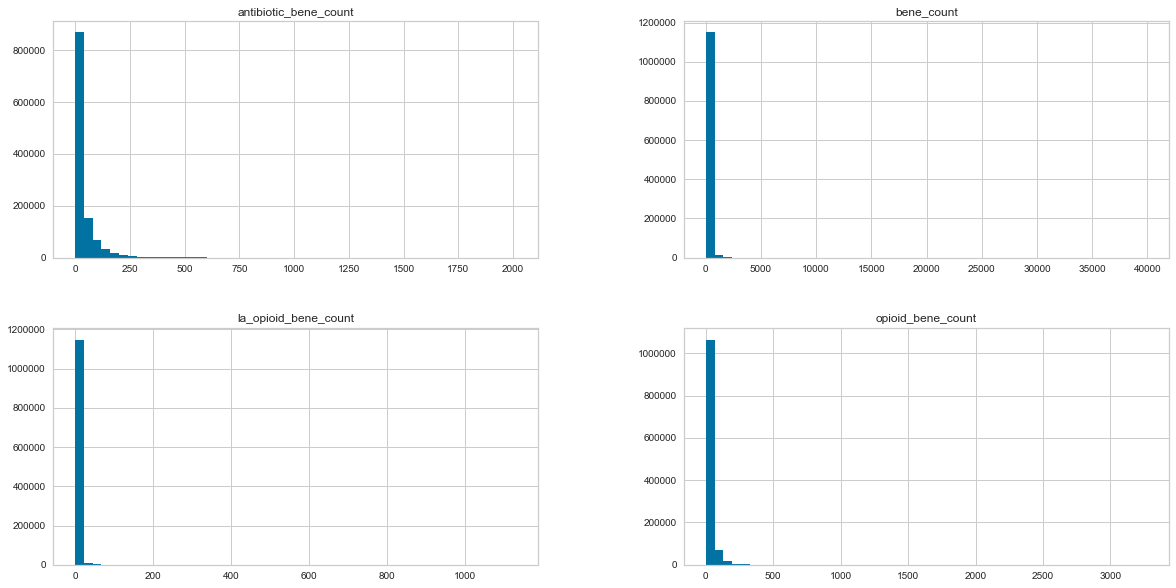

In [34]:
#Looking at distribution of these variables
df[kf_null].hist(figsize=(20,10), bins=50) 

In [35]:
df['la_opioid_bene_count'].value_counts()

0.0       909133
5.0       215469
11.0        3701
12.0        3339
13.0        2736
14.0        2413
15.0        2071
16.0        1809
17.0        1577
18.0        1372
19.0        1199
20.0        1087
21.0         997
22.0         904
23.0         754
24.0         679
25.0         628
26.0         535
27.0         506
28.0         463
30.0         397
29.0         388
31.0         383
32.0         330
33.0         304
34.0         287
35.0         281
36.0         245
37.0         232
38.0         217
           ...  
383.0          1
386.0          1
387.0          1
391.0          1
861.0          1
446.0          1
944.0          1
445.0          1
883.0          1
891.0          1
442.0          1
440.0          1
437.0          1
435.0          1
430.0          1
429.0          1
428.0          1
425.0          1
421.0          1
420.0          1
417.0          1
412.0          1
1131.0         1
405.0          1
404.0          1
399.0          1
398.0          1
397.0         

In [36]:
#Since there are so many 0s skewing the histogram, look at distribution excluding the 0s
la_none = df['la_opioid_bene_count'] > 0
la_noskew = df[la_none]

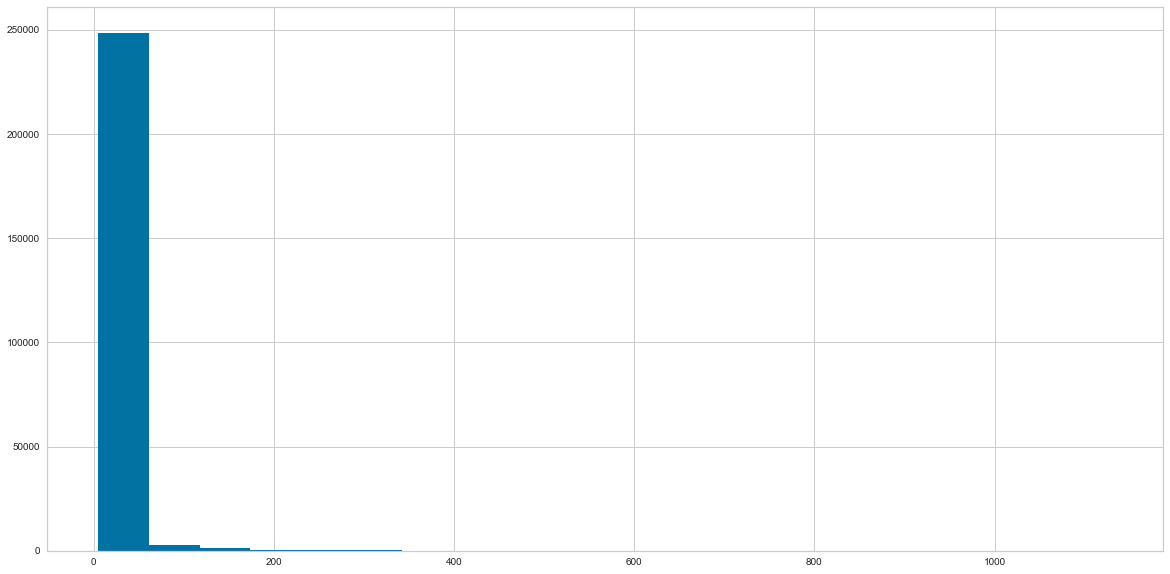

In [37]:
la_noskew['la_opioid_bene_count'].hist(figsize=(20,10), bins = 20)

Even by removing the 0s from the distribution, these still skew left

In [38]:
#Exploring claim counts where null values mean < 11
claims = ['opioid_claim_count', 'la_opioid_claim_count', 'antibiotic_claim_count']
df[claims].describe()

,opioid_claim_count,la_opioid_claim_count,antibiotic_claim_count
count,1.162814e+06,1.162846e+06,1.162756e+06
mean,6.546160e+01,8.451168e+00,5.178712e+01
std,2.653090e+02,6.403888e+01,1.014339e+02
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,5.000000e+00
50%,5.000000e+00,0.000000e+00,1.600000e+01
75%,3.500000e+01,0.000000e+00,5.600000e+01
max,2.059900e+04,6.056000e+03,7.585000e+03


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023A8B1A2648>,
      dtype=object)

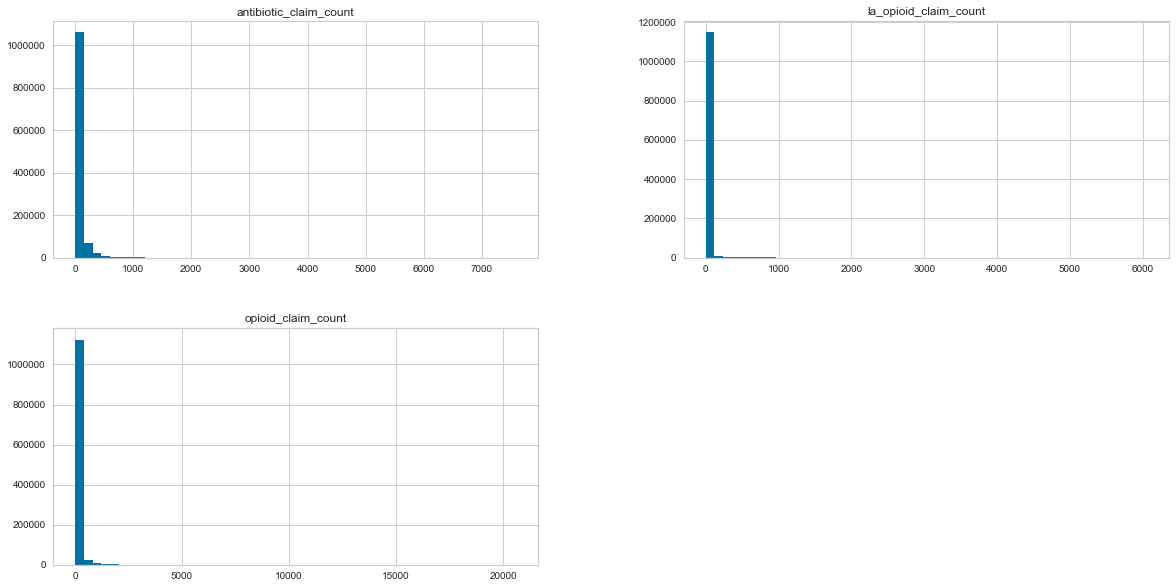

In [39]:
df[claims].hist(figsize=(20,10), bins=50)